In [1]:
from pathlib import Path
from typing import Any, Literal

import numpy as np
import pandas as pd
import torch
from PIL import Image
from numpy.typing import NDArray
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from transformers import AutoFeatureExtractor, AutoModel

In [2]:
print(torch.cuda.is_available())
# !pip requirements txt

False


In [3]:
# Notice this is a similarity function, not a distance function
def cosine_similarity(vector_a: NDArray, vector_b: NDArray) -> float:
    return float(np.dot(vector_a, vector_b) / (np.linalg.norm(vector_a) * np.linalg.norm(vector_b)))


# Notice this is a distance function, not a similarity function
def euclidean_distance(vector_a: NDArray, vector_b: NDArray) -> float:
    return float(np.linalg.norm(vector_a - vector_b))


# Calculate cosine similarities between a query embedding and a list of item embeddings
def calculate_cosine_similarities(query_embedding: NDArray,
                                  all_embeddings: NDArray) -> list[float]:
    similarities = []
    for i in range(len(all_embeddings)):
        similarities.append(cosine_similarity(query_embedding, all_embeddings[i]))
    return list(map(lambda x: round(x, 3), similarities))

# Calculate cosine distances between a query embedding and a list of item embeddings
def calculate_euclidean_distances(query_embedding: NDArray, all_embeddings: NDArray) -> list[float]:
    distances = []
    for i in range(len(all_embeddings)):
        distances.append( euclidean_distance(query_embedding, all_embeddings[i]))
    return list(map(lambda x: round(x, 3), distances))

# Use argument sorting to return most similar objects
# depending on the metric used
# If metric is "distance", smaller values are more similar
# If metric is "similarity", larger values are more similar
def most_similar_objects(distances: NDArray, objects: list[Any],
                         metric: Literal["distance", "similarity"] = "distance", n: int = 3) -> list:
    indexes = np.argsort(distances)
    if(metric == "similarity"):
        indexes = indexes[::-1]
        
    closest_n_objects = [objects[i] for i in indexes[:n]]
    return closest_n_objects

In [4]:
sentences = [
    "Intellectual growth expands our capacity to engage with diverse perspectives.",
    "Natural environments offer a peaceful respite from daily stress.",
    "Persistence in the face of challenges is the key to accomplishing your goals.",
    "The natural world provides essential balance to our technological lives.",
    "Education provides the tools needed to navigate life's complexities.",
    "Steadfast commitment to your path will bring rewards, even when progress seems slow.",
    "Regular contact with nature improves overall well-being.",
    "Continued determination in difficult circumstances yields achievement in the end.",
    "The pursuit of knowledge opens doors to new possibilities.",
    "Immersion in wilderness settings restores mental clarity.",
    "Those who maintain effort despite obstacles will ultimately triumph.",
    "Learning enriches our understanding of the world around us.",
    "Spending time outdoors rejuvenates the human spirit.",
    "Hard work and dedication eventually lead to success."
]
len(sentences)

14

In [5]:
vectorizer = TfidfVectorizer()
embedded_sentences = vectorizer.fit_transform(sentences)
embedded_sentences = embedded_sentences.toarray()
embedded_sentences.shape

(14, 104)

In [6]:
embedder = SentenceTransformer("all-MiniLM-L6-v2")
embedded_sentences = embedder.encode(sentences)
embedded_sentences

array([[ 0.08699887, -0.03915361,  0.0155196 , ...,  0.0126487 ,
        -0.00708163, -0.04908187],
       [ 0.11443501,  0.06025406,  0.116734  , ...,  0.01577802,
        -0.02639238,  0.01526284],
       [-0.02406544,  0.08903705, -0.03178172, ...,  0.00367673,
        -0.06579673,  0.06285904],
       ...,
       [ 0.01617094,  0.03486402,  0.01971144, ...,  0.00370608,
        -0.02825438, -0.02250763],
       [ 0.09061953,  0.08363248,  0.13680767, ..., -0.01375802,
        -0.09141327, -0.02197981],
       [-0.01184277,  0.03575744,  0.02364085, ..., -0.00943862,
         0.05000319,  0.0830595 ]], shape=(14, 384), dtype=float32)

In [7]:
# embedded_sentences

In [8]:
idx = 9
sentences[idx]

'Immersion in wilderness settings restores mental clarity.'

In [9]:
cosine_similarities = calculate_cosine_similarities(embedded_sentences[idx], embedded_sentences)
print(cosine_similarities)

[0.34, 0.397, 0.255, 0.234, 0.3, 0.221, 0.451, 0.254, 0.311, 1.0, 0.209, 0.373, 0.56, 0.174]


In [10]:
similar_sentences = most_similar_objects(cosine_similarities, sentences, "similarity", 4)
similar_sentences

['Immersion in wilderness settings restores mental clarity.',
 'Spending time outdoors rejuvenates the human spirit.',
 'Regular contact with nature improves overall well-being.',
 'Natural environments offer a peaceful respite from daily stress.']

In [11]:
euclidean_distances = calculate_euclidean_distances(
    embedded_sentences[idx],
    embedded_sentences)
print(euclidean_distances)

[1.149, 1.098, 1.221, 1.238, 1.183, 1.248, 1.048, 1.221, 1.174, 0.0, 1.258, 1.119, 0.938, 1.285]


In [12]:
similar_sentences = most_similar_objects(euclidean_distances, sentences, "distance", 4)
similar_sentences

['Immersion in wilderness settings restores mental clarity.',
 'Spending time outdoors rejuvenates the human spirit.',
 'Regular contact with nature improves overall well-being.',
 'Natural environments offer a peaceful respite from daily stress.']

In [13]:
similarities = embedder.similarity(embedded_sentences[idx], embedded_sentences)
similarities = similarities.cpu().view(-1).numpy()
similarities = similarities.round(3)
print(similarities)

[0.34  0.397 0.255 0.234 0.3   0.221 0.451 0.254 0.311 1.    0.209 0.373
 0.56  0.174]


In [14]:
def project_vectors(data: NDArray, technique: str = "tsne", **options):
    if technique == "pca":
        transformer = PCA(**options)
    elif technique == "tsne":
        transformer = TSNE(**options)
    elif technique == "umap":
        raise NotImplementedError("UMAP is not yet supported.")
    else:
        raise ValueError(
            f"Invalid technique: {technique}. Choose from 'pca', 'tsne', or 'umap'."
        )

    transformed_data = transformer.fit_transform(data)
    return transformed_data

In [15]:
embedded_sentences

array([[ 0.08699887, -0.03915361,  0.0155196 , ...,  0.0126487 ,
        -0.00708163, -0.04908187],
       [ 0.11443501,  0.06025406,  0.116734  , ...,  0.01577802,
        -0.02639238,  0.01526284],
       [-0.02406544,  0.08903705, -0.03178172, ...,  0.00367673,
        -0.06579673,  0.06285904],
       ...,
       [ 0.01617094,  0.03486402,  0.01971144, ...,  0.00370608,
        -0.02825438, -0.02250763],
       [ 0.09061953,  0.08363248,  0.13680767, ..., -0.01375802,
        -0.09141327, -0.02197981],
       [-0.01184277,  0.03575744,  0.02364085, ..., -0.00943862,
         0.05000319,  0.0830595 ]], shape=(14, 384), dtype=float32)

In [16]:
reduced_embeddings = project_vectors(embedded_sentences, technique="tsne", n_components=2, random_state=0, perplexity=5)
reduced_embeddings.shape
# reduced_embeddings
reduced_embeddings

array([[ 21.851166 ,  28.826014 ],
       [-28.447231 ,  46.03088  ],
       [ 14.769835 ,  -5.5582333],
       [ -6.004657 ,  40.257862 ],
       [ 15.735298 ,  42.950783 ],
       [  4.245484 , -34.954647 ],
       [-36.29192  ,  56.242805 ],
       [ 25.84318  , -21.419308 ],
       [ 13.1605625,  16.797253 ],
       [-50.68737  ,  43.72581  ],
       [  3.512313 , -20.606226 ],
       [  6.5166755,  35.572346 ],
       [-40.386684 ,  40.004356 ],
       [ 14.237353 , -19.665535 ]], dtype=float32)

In [17]:
# dataframe with reduced embeddings

df = pd.DataFrame(reduced_embeddings, columns=["x", "y"])
df["sentence"] = sentences
df

,x,y,sentence
0,21.851166,28.826014,Intellectual growth expands our capacity to en...
1,-28.447231,46.030880,Natural environments offer a peaceful respite ...
2,14.769835,-5.558233,Persistence in the face of challenges is the k...
3,-6.004657,40.257862,The natural world provides essential balance t...
4,15.735298,42.950783,Education provides the tools needed to navigat...
5,4.245484,-34.954647,Steadfast commitment to your path will bring r...
6,-36.291920,56.242805,Regular contact with nature improves overall w...
7,25.843180,-21.419308,Continued determination in difficult circumsta...
8,13.160563,16.797253,The pursuit of knowledge opens doors to new po...
9,-50.687370,43.725811,Immersion in wilderness settings restores ment...


In [18]:
import plotly.express as px

fig = px.scatter(df, x="x", y="y", text="sentence")

fig.update_traces(textfont_size=10, marker=dict(size=10))
fig.update_layout(template="plotly")

fig.show()

In [20]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("prasunroy/natural-images")

print("Path to dataset files:", path)

ConnectionError: HTTPSConnectionPool(host='www.kaggle.com', port=443): Max retries exceeded with url: /api/v1/datasets/view/prasunroy/natural-images (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000023F128AD9C0>: Failed to resolve 'www.kaggle.com' ([Errno 11001] getaddrinfo failed)"))

In [21]:
path = Path('C:\\Users\\antig\\.cache\\kagglehub\\datasets\\prasunroy\\natural-images\\versions\\1')

In [22]:
paths_to_images = list(path.glob("**/*.jpg"))

In [23]:
path_df = pd.DataFrame(paths_to_images, columns=["path"])
path_df['class'] = path_df['path'].apply(lambda x: x.parent.name)
path_df = path_df.sample(n=50).reset_index(drop=True)
path_df

,path,class
0,C:\Users\antig\.cache\kagglehub\datasets\prasu...,person
1,C:\Users\antig\.cache\kagglehub\datasets\prasu...,airplane
2,C:\Users\antig\.cache\kagglehub\datasets\prasu...,cat
3,C:\Users\antig\.cache\kagglehub\datasets\prasu...,person
4,C:\Users\antig\.cache\kagglehub\datasets\prasu...,flower
5,C:\Users\antig\.cache\kagglehub\datasets\prasu...,dog
6,C:\Users\antig\.cache\kagglehub\datasets\prasu...,person
7,C:\Users\antig\.cache\kagglehub\datasets\prasu...,cat
8,C:\Users\antig\.cache\kagglehub\datasets\prasu...,flower
9,C:\Users\antig\.cache\kagglehub\datasets\prasu...,flower


In [24]:
def generate_image_embeddings(image_path: str | Path, model_name: str = "microsoft/resnet-50"):
    """
    Generate embeddings for an image using a pretrained model from HuggingFace.
    
    Args:
        image_path (str): Path to the image file
        model_name (str): Name of the pretrained model to use
                          Default is "microsoft/resnet-50"
    
    Returns:
        numpy.ndarray: Image embedding vector
    """
    image = Image.open(image_path)

    feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    inputs = feature_extractor(images=image, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)

    if hasattr(outputs, 'pooler_output'):
        embeddings = outputs.pooler_output.numpy()
    else:
        embeddings = outputs.last_hidden_state.mean(dim=1).numpy()

    return embeddings.squeeze()


embeddings = generate_image_embeddings(path_df.iloc[0].path)

C:\Users\antig\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\models\convnext\feature_extraction_convnext.py:28: FutureWarning:

The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.



In [25]:
def generate_image_embeddings_as_histogram(image_path: str | Path):
    """
    Generate embeddings for an image using a pretrained model from HuggingFace.
    
    Args:
        image_path (str): Path to the image file
    
    Returns:
        numpy.ndarray: Image embedding vector
    """
    image = Image.open(image_path)
    image = image.resize((224, 224))

    # Convert image to numpy array
    image = np.array(image)

    # Create histogram
    histogram, _ = np.histogram(image, bins=256, range=(0, 256))

    return histogram

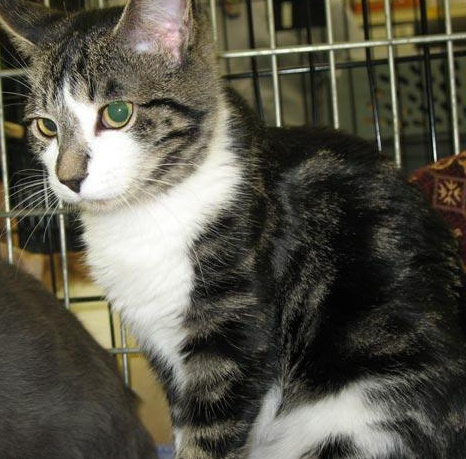

In [40]:
idx = 2
Image.open(path_df.iloc[idx].path)


In [49]:
embedded_images = [generate_image_embeddings(path_df['path'][i]) for i in range(len(path_df))]

In [50]:
cosine_similarities = calculate_cosine_similarities(embedded_images[idx], embedded_images)

In [51]:
similar_images = most_similar_objects(cosine_similarities, path_df['path'], "similarity", 4)
similar_images

[WindowsPath('C:/Users/antig/.cache/kagglehub/datasets/prasunroy/natural-images/versions/1/natural_images/cat/cat_0139.jpg'),
 WindowsPath('C:/Users/antig/.cache/kagglehub/datasets/prasunroy/natural-images/versions/1/natural_images/cat/cat_0210.jpg'),
 WindowsPath('C:/Users/antig/.cache/kagglehub/datasets/prasunroy/natural-images/versions/1/data/natural_images/cat/cat_0640.jpg'),
 WindowsPath('C:/Users/antig/.cache/kagglehub/datasets/prasunroy/natural-images/versions/1/natural_images/cat/cat_0500.jpg')]

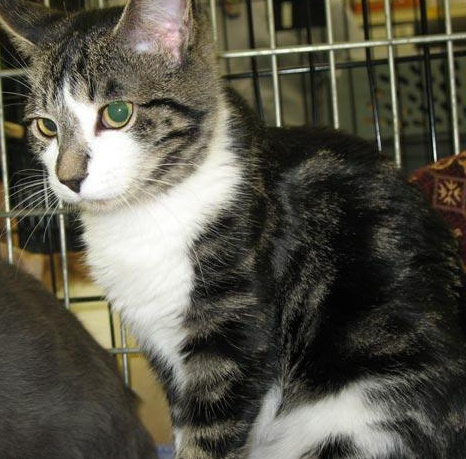

In [52]:
Image.open(similar_images[0])

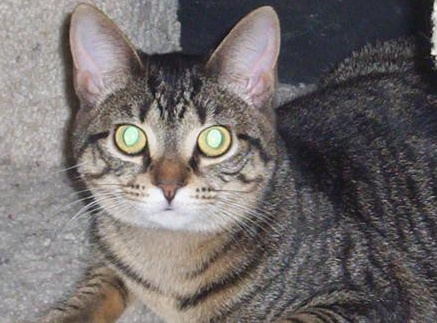

In [53]:
Image.open(similar_images[1])

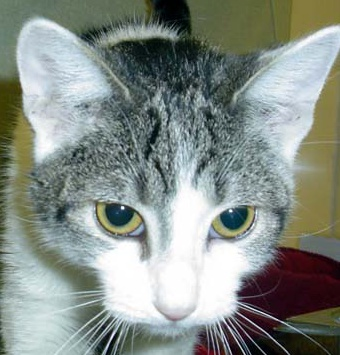

In [54]:
Image.open(similar_images[2])

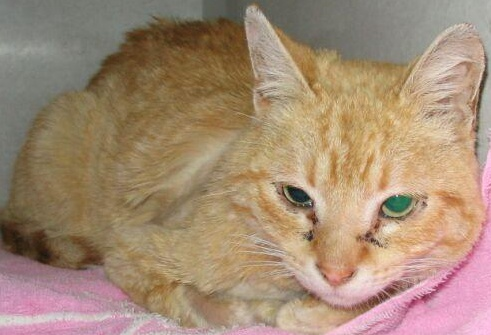

In [55]:
Image.open(similar_images[3])

In [56]:
euclidean_distances = calculate_euclidean_distances(embedded_images[idx], embedded_images)

In [57]:
similar_images = most_similar_objects(euclidean_distances, path_df['path'], "distances", 4)
similar_images

[WindowsPath('C:/Users/antig/.cache/kagglehub/datasets/prasunroy/natural-images/versions/1/natural_images/cat/cat_0139.jpg'),
 WindowsPath('C:/Users/antig/.cache/kagglehub/datasets/prasunroy/natural-images/versions/1/natural_images/cat/cat_0210.jpg'),
 WindowsPath('C:/Users/antig/.cache/kagglehub/datasets/prasunroy/natural-images/versions/1/data/natural_images/cat/cat_0640.jpg'),
 WindowsPath('C:/Users/antig/.cache/kagglehub/datasets/prasunroy/natural-images/versions/1/natural_images/cat/cat_0500.jpg')]